# Set Library Path

In [1]:
.libPaths("/home/vhaghani/anaconda3/envs/jupyter_nb_R4.4.2/lib/R/library")

# Load Libraries

In [3]:
library(enrichR)
library(dplyr)
library(rtracklayer)
library(GenomicRanges)
library(openxlsx)
library(readxl)
library(glue)
library(ggplot2)
library(viridis)
library(tidyr)
library(comethyl)

# Load Data

In [8]:
modules <- readRDS("Modules.rds")

In [9]:
regions <- modules$regions

In [10]:
# Module eigengenes
MEs <- modules$MEs

In [11]:
# Sample trait data
colData <- openxlsx::read.xlsx("sample_info.xlsx", rowNames = TRUE)

# Make Heatmap

In [12]:
# Test correlations between module eigennodes and sample traits
MEtraitCor <- getMEtraitCor(MEs, colData = colData, corType = "bicor",
                            file = "ME_Trait_Correlation_Stats.txt")

[getMEtraitCor] Testing associations between module eigennodes and sample traits using bicor correlation

[getMEtraitCor] Saving file as ME_Trait_Correlation_Stats.txt



In [13]:
# Module dendrogram
moduleDendro <- getDendro(MEs, distance = "bicor")

[getDendro] Clustering with bicor correlation as the distance



In [14]:
# Trait dendrogram with error handling
traitDendro <- tryCatch({
  getCor(MEs, y = colData, corType = "bicor", robustY = FALSE) %>%
    getDendro(transpose = TRUE)
}, error = function(e) {
  cat("Bicor failed for trait dendrogram, trying pearson correlation...\n")
  getCor(MEs, y = colData, corType = "pearson") %>%
    getDendro(transpose = TRUE)
})

[getDendro] Transposing data

[getCor] Calculating correlations using bicor correlation

[getDendro] Clustering by euclidean distance



In [15]:
# Sort Variables
sorted_trait_order <- traitDendro$order[order(traitDendro$order)]

# Get the corresponding module labels based on the order
module_order <- moduleDendro$order
ordered_module_labels <- moduleDendro$labels[module_order]

In [16]:
# Save ordered_module_labels to a text file
write.table(ordered_module_labels, 
            file = "ME_Trait_Correlation_Heatmap_Module_Order.txt", 
            row.names = FALSE, 
            col.names = FALSE, 
            quote = FALSE)

[plotMEtraitCor] Plotting ME trait correlation heatmap

[plotMEtraitCor] Using colors in column names for x-axis labels

[plotMEtraitCor] Saving plot as ME_Trait_Correlation_Heatmap.pdf



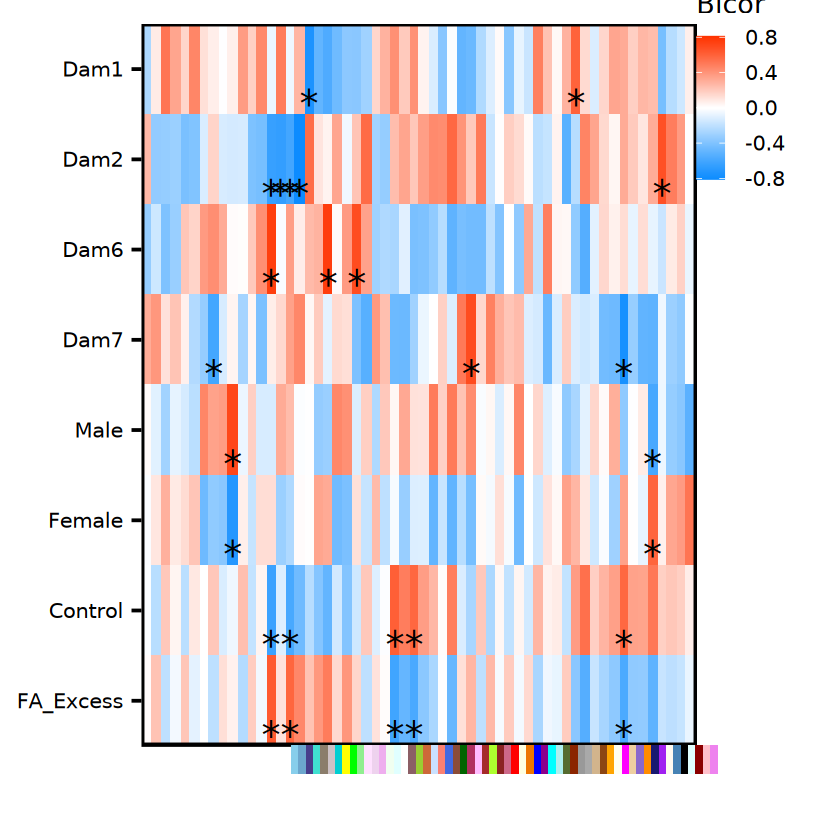

In [17]:
# ME-trait correlation heatmap
plotMEtraitCor(MEtraitCor, moduleOrder = moduleDendro$order,
               traitOrder = sorted_trait_order,
               colColorMargins = c(-2.5, 4.2, 2.7, 11.25), 
               file = "ME_Trait_Correlation_Heatmap.pdf")

# Process Data

Select modules of interest based on significance in module trait correlations.

In [18]:
# Filter MEtraitCor for significant modules only (p-values less than 0.05)
modules_of_interest <- MEtraitCor %>%
    filter(p < 0.05) %>%
    distinct(module) 

# Create module list
modules_of_interest <- as.character(unique(modules_of_interest$module))

# Remove grey if present
modules_of_interest <- modules_of_interest[modules_of_interest != "grey"]

In [20]:
# Confirm subsetting
for (i in seq_along(modules_of_interest)) {
    module <- modules_of_interest[i]
    print(paste(i, module))
}

[1] "1 yellowgreen"
[1] "2 lightsteelblue1"
[1] "3 salmon4"
[1] "4 magenta"
[1] "5 white"
[1] "6 purple"
[1] "7 darkmagenta"
[1] "8 lightcyan1"
[1] "9 yellow"
[1] "10 lightcyan"
[1] "11 honeydew1"
[1] "12 lightpink4"
[1] "13 black"
[1] "14 brown"
[1] "15 brown4"
[1] "16 lightgreen"


In [19]:
# Filter out modules that are not of interest
regions <- regions %>%
  filter(module %in% modules_of_interest)

In [21]:
# View
head(regions)

,RegionID,chr,start,end,width,n,covMin,covMean,covSD,methMean,methSD,module,membership,hubRegion
,<chr>,<chr>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<lgl>
1,Region_1,chr1,3007430,3007682,252,4,14,22.33333,7.202693,0.7972004,0.08512359,magenta,0.4652672,FALSE
2,Region_6,chr1,3017445,3017736,291,4,10,23.00000,9.544156,0.7985774,0.12548113,yellow,0.6728349,FALSE
3,Region_9,chr1,3030034,3030139,105,3,14,22.00000,4.631905,0.8749088,0.06399012,purple,0.7429895,FALSE
4,Region_12,chr1,3045448,3045765,317,4,9,22.66667,9.227758,0.9429644,0.06775824,yellow,0.8705777,FALSE
5,Region_16,chr1,3063374,3063494,120,4,9,17.83333,7.132937,0.8694196,0.10946624,lightgreen,0.5455708,FALSE
6,Region_19,chr1,3070337,3070454,117,4,10,22.83333,7.744010,0.8956680,0.09571400,lightcyan,0.6219798,FALSE


In [22]:
# View MEtraitCor
head(MEtraitCor)

# See module list
print(unique(MEtraitCor$module))

,module,trait,nObs,bicor,Z,t,p
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ivory,Dam1,12,0.28682864,0.9332108,0.9468152,0.3660501
2,ivory,Dam2,12,-0.52958538,-1.8643801,1.9742799,0.0765977
3,ivory,Dam6,12,0.03324189,0.1051588,0.1051782,0.9183142
4,ivory,Dam7,12,0.18871584,0.6040116,0.6076910,0.5569400
5,ivory,Male,12,-0.35441619,-1.1715776,1.1985638,0.2583300
6,ivory,Female,12,0.35441619,1.1715776,1.1985638,0.2583300


 [1] ivory           sienna3         yellowgreen     lightsteelblue1
 [5] salmon4         magenta         paleturquoise   cyan           
 [9] darkolivegreen  darkgrey        green           orangered4     
[13] grey60          white           salmon          darkturquoise  
[17] purple          blue            darkmagenta     skyblue        
[21] lightcyan1      lightyellow     yellow          pink           
[25] royalblue       maroon          plum1           lightcyan      
[29] red             thistle2        bisque4         skyblue3       
[33] darkslateblue   navajowhite2    honeydew1       plum2          
[37] lavenderblush3  lightpink4      turquoise       saddlebrown    
[41] thistle1        mediumpurple3   darkorange      midnightblue   
[45] darkgreen       black           brown           brown4         
[49] palevioletred3  floralwhite     darkorange2     steelblue      
[53] lightgreen      orange          greenyellow     tan            
[57] darkred         violet       

In [23]:
# Filter out modules that are not of interest
MEtraitCor <- MEtraitCor %>%
  mutate(module = as.character(module)) %>%
  filter(module %in% modules_of_interest)

In [24]:
# View MEtraitCor
head(MEtraitCor)

# See module list
print(unique(MEtraitCor$module))

,module,trait,nObs,bicor,Z,t,p
,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,yellowgreen,Dam1,12,-0.74820065,-3.06378822,3.56611335,0.005128801
2,yellowgreen,Dam2,12,0.55663684,1.98574229,2.11884162,0.060140746
3,yellowgreen,Dam6,12,0.25789306,0.83436706,0.84408181,0.418358325
4,yellowgreen,Dam7,12,0.03594185,0.11370710,0.11373161,0.911701515
5,yellowgreen,Male,12,-0.01151168,-0.03640473,0.03640554,0.971675481
6,yellowgreen,Female,12,0.01151168,0.03640473,0.03640554,0.971675481


 [1] "yellowgreen"     "lightsteelblue1" "salmon4"         "magenta"        
 [5] "white"           "purple"          "darkmagenta"     "lightcyan1"     
 [9] "yellow"          "lightcyan"       "honeydew1"       "lightpink4"     
[13] "black"           "brown"           "brown4"          "lightgreen"     


In [25]:
# Define traits to remove
traits_to_remove <- c("Dam1", "Dam2", "Dam6", "Dam7", "Female", "Male")

In [26]:
# Remove modules that are significant only in traits to remove
modules_to_keep <- MEtraitCor %>%
  filter(!trait %in% traits_to_remove) %>%
  group_by(module) %>%
  filter(any(p < 0.05)) %>%
  pull(module) %>%
  unique()

In [27]:
# Filter MEtraitCor to keep only these modules
MEtraitCor <- MEtraitCor %>%
  filter(module %in% modules_to_keep)

In [28]:
# Remove all traits to remove from MEtraitCor
MEtraitCor <- MEtraitCor %>%
  mutate(trait = as.character(trait)) %>%
  filter(!trait %in% traits_to_remove)

In [34]:
print("Remaining modules after filtering:")
remaining_modules <- unique(MEtraitCor$module)
print(remaining_modules)

print("Remaining traits after filtering:")
remaining_traits <- unique(MEtraitCor$trait)
print(remaining_traits)

[1] "Remaining modules after filtering:"
[1] "white"     "purple"    "honeydew1" "brown"     "brown4"   
[1] "Remaining traits after filtering:"
[1] "Control"   "FA_Excess"


In [35]:
# Set axis variable labels
moduleOrder <- remaining_modules
sorted_trait_order <- sort(remaining_traits)

[plotMEtraitCor] Plotting ME trait correlation heatmap

[plotMEtraitCor] Saving plot as ME_Trait_Correlation_Heatmap.pdf



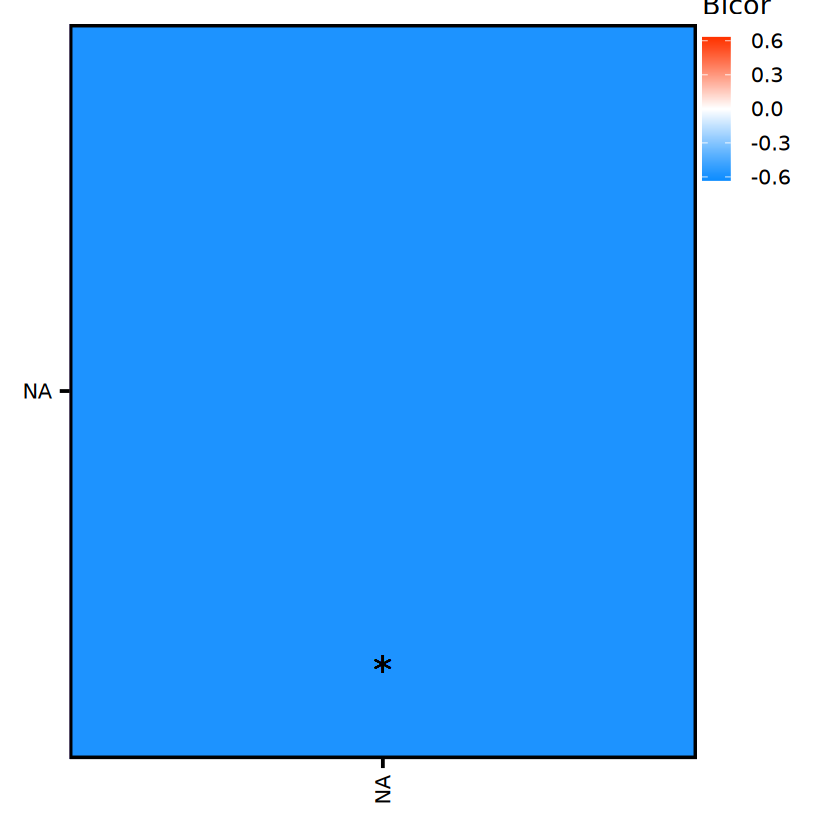

In [36]:
# ME-trait correlation heatmap
plotMEtraitCor(MEtraitCor, moduleOrder = moduleDendro,
               traitOrder = sorted_trait_order,
               colColorMargins = c(-2.5, 4.2, 2.7, 11.25), 
               file = "ME_Trait_Correlation_Heatmap.pdf")

# Annotate Regions

In [ ]:
# Read the GTF annotation file
gtf_file <- "/share/lasallelab/genomes/mm10/mm10.refGene.gtf"
gtf_data <- import(gtf_file)

# View
head(gtf_data)

In [ ]:
# Create GRanges object for regions
gr_regions <- GRanges(seqnames = regions$chr,
                      ranges = IRanges(start = regions$start, end = regions$end))

In [ ]:
# Extract transcript entries from the GTF data
gtf_transcripts <- gtf_data[gtf_data$type == "transcript"]

In [ ]:
# Create GRanges object for gene annotations
gr_genes <- GRanges(seqnames = seqnames(gtf_transcripts),
                    ranges = IRanges(start = start(gtf_transcripts), end = end(gtf_transcripts)),
                    gene_name = mcols(gtf_transcripts)$gene_name)

In [ ]:
# Find overlaps between regions and gene annotations
overlaps <- findOverlaps(gr_regions, gr_genes)

In [ ]:
# Create a new column for gene names in the regions data frame
regions$gene_name <- NA
regions$gene_name[queryHits(overlaps)] <- gr_genes$gene_name[subjectHits(overlaps)]

In [ ]:
# View annotated regions
head(regions)

# Gene Ontology

In [ ]:
# Create a list of gene names per module
module_genes <- regions %>%
  group_by(module) %>%
  summarize(unique_genes = list(unique(gene_name[!is.na(gene_name)])), .groups = 'drop')

# View
head(module_genes)

In [ ]:
# Count genes per module
module_genes_length <- module_genes %>%
  mutate(num_genes = sapply(unique_genes, length)) %>%
  select(module, num_genes)

# View
print(module_genes_length)

In [ ]:
# Iterate over each module
for (module in module_genes$module) {
  # Read in gene list
  gene_list <- module_genes$unique_genes[[which(module_genes$module == module)]]
    
  tryCatch({
    # Perform the enrichR analysis on the gene list for the current module
    enrichr_results <- enrichr(gene_list, c("GO_Biological_Process_2023",
                                                     "GO_Cellular_Component_2023",
                                                     "GO_Molecular_Function_2023",
                                                     "KEGG_2019_Mouse",
                                                     "Panther_2016",
                                                     "Reactome_2016",
                                                     "RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO"))
    
    # Check if enrichr_results is empty
    if (length(enrichr_results) == 0) {
      cat("No results for module", module, "\n")
      next
    }
    
    # Save Enrichr outputs
    wb <- createWorkbook()
    
    for (i in seq_along(enrichr_results)) {
      # Extract the data frame from the list
      df <- enrichr_results[[i]]
      
      # Check if the data frame is empty
      if (nrow(df) == 0) {
        cat("Empty data frame for", names(enrichr_results)[i], "in module", module, "\n")
        next
      }
      
      # Define the original sheet name
      original_sheet_name <- names(enrichr_results)[i]
      
      # Modify the sheet name if it's specifically "RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO"
      sheet_name <- if (original_sheet_name == "RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO") {
        "RNAseq_DiseaseGene_DrugSigs_GEO"
      } else {
        original_sheet_name
      }
      
      # Add the data frame as a new sheet in the Excel workbook
      addWorksheet(wb, sheet_name)
      writeData(wb, sheet = sheet_name, x = df)
    }
    
    # Save the Excel workbook
    saveWorkbook(wb, paste0(module, "_enrichr_results.xlsx"), overwrite = TRUE)
    
    # Function to plot and save the results
    plot_and_save <- function(df, filename, title) {
      if (nrow(df) == 0) {
        cat("Empty data frame for", title, "in module", module, "\n")
        return()
      }
      pdf(filename, height = 7, width = 15)
      print(plotEnrich(df, showTerms = 25, numChar = 75, y = "Count", orderBy = "P.value") + ggtitle(title))
      dev.off()
    }
    
    # Plot and save Enrichr results
    plot_and_save(enrichr_results$GO_Biological_Process_2023, 
                  paste0(module, "_GO_Biological_Process_2023.pdf"), 
                  paste("GO_Biological_Process_2023 for", module, "module"))
    
    plot_and_save(enrichr_results$GO_Cellular_Component_2023, 
                  paste0(module, "_GO_Cellular_Component_2023.pdf"), 
                  paste("GO_Cellular_Component_2023 for", module, "module"))
    
    plot_and_save(enrichr_results$GO_Molecular_Function_2023, 
                  paste0(module, "_GO_Molecular_Function_2023.pdf"), 
                  paste("GO_Molecular_Function_2023 for", module, "module"))
    
    plot_and_save(enrichr_results$KEGG_2019_Mouse, 
                  paste0(module, "_KEGG_2019_Mouse.pdf"), 
                  paste("KEGG_2019_Mouse for", module, "module"))
    
    plot_and_save(enrichr_results$Panther_2016, 
                  paste0(module, "_Panther_2016.pdf"), 
                  paste("Panther_2016 for", module, "module"))
    
    plot_and_save(enrichr_results$Reactome_2016, 
                  paste0(module, "_Reactome_2016.pdf"), 
                  paste("Reactome_2016 for", module, "module"))
    
    plot_and_save(enrichr_results$`RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO`, 
                  paste0(module, "_RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO.pdf"), 
                  paste("RNA-Seq_Disease_Gene_and_Drug_Signatures_from_GEO for", module, "module"))
    
  }, error = function(e) {
    cat("Error occurred for module", module, ": ", conditionMessage(e), "\n")
    # Log the error to a file for further inspection
    write(paste("Error occurred for module", module, ": ", conditionMessage(e), "\n"), file = "error_log.txt", append = TRUE)
    # Continue to the next module
    next
  })
}

# Visualize GO Results

## Top 25 Dot Plots (Priotizing Overlap)

In [ ]:
# List of GO databases
databases <- c("GO_Biological_Process_2023", "GO_Cellular_Component_2023", "GO_Molecular_Function_2023",
               "KEGG_2019_Mouse", "Panther_2016", "Reactome_2016", "RNAseq_DiseaseGene_DrugSigs_GEO")

In [ ]:
# Store GO data into data frame

# Initialize an empty dataframe
all_data <- data.frame()

# Iterate over each module and read in the corresponding Excel file
for (module in module_genes$module) {
  file_path <- glue("{module}_enrichr_results.xlsx")
  
  for (database in databases) {
    try({
      # Read the data from the Excel file
      df <- read_excel(file_path, sheet = database)
      
      if (nrow(df) == 0) {
        next  # Skip to the next database if no data
      }
      
      # Select the required columns and add module and database information
      df <- df %>%
        select(Term, Adjusted.P.value, Odds.Ratio) %>%
        mutate(Module = module, Database = database)
      
      # Append to the dataframe
      all_data <- bind_rows(all_data, df)
      
    }, silent = TRUE)
  }
}

# Check if any data was read
if (nrow(all_data) == 0) {
  stop("No data read from any of the Excel files.")
}

# Display the combined dataframe
head(all_data)

In [ ]:
# Filter out rows where the Adjusted.P.value is less than 0.1
all_data <- all_data %>%
  filter(Adjusted.P.value <= 0.05)

# Display the filtered dataframe
head(all_data)

In [ ]:
# Count the number of total terms and unique terms for each database
database_term_counts <- all_data %>%
  group_by(Database) %>%
  summarise(
    Total_Terms = n(),
    Unique_Terms = n_distinct(Term)
  )

# Print the table
print(database_term_counts)

In [ ]:
# Calculate the number of modules each term appears in for each database
term_module_counts <- all_data %>%
  group_by(Database, Term) %>%
  summarise(ModuleCount = n_distinct(Module), .groups = 'drop')

# Rank the terms within each database by the number of modules they appear in
ranked_terms <- term_module_counts %>%
  arrange(Database, desc(ModuleCount)) %>%
  group_by(Database) %>%
  slice_head(n = 25) %>%
  ungroup()

# Merge with the original data to filter the top 25 terms per database
filtered_data_top_25 <- all_data %>%
  semi_join(ranked_terms, by = c("Database", "Term"))

# Print the filtered data
head(filtered_data_top_25)

In [ ]:
# Count the number of total terms and unique terms for each database
filtered_database_term_counts <- filtered_data_top_25 %>%
  group_by(Database) %>%
  summarise(
    Total_Terms = n(),
    Unique_Terms = n_distinct(Term)
  )

# Print the table
print(filtered_database_term_counts)

In [ ]:
# Create plots for each database
for (database in unique(filtered_data_top_25$Database)) {
  database_filtered_data <- filtered_data_top_25 %>%
    filter(Database == database)
  
  if (nrow(database_filtered_data) > 0) {
    dot_plot <- ggplot(database_filtered_data, aes(x = Module, y = Term, size = Odds.Ratio, fill = Adjusted.P.value)) +
      geom_point(shape = 21) +
      scale_fill_viridis() +
      xlab('') + ylab('') +
      labs(
        title = 'Top Enrichr Terms Across Modules',
        subtitle = glue('{database}')
      ) +
      theme(
        panel.background = element_rect(fill = "white", color = NA),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.line = element_line(color = "black"),
        plot.background = element_rect(fill = "white", color = NA),
        axis.text.x = element_text(angle = 90, hjust = 1)
      )
    
    # Save the dot plot with the database name in the filename
    ggsave(filename = glue("top_25_dot_plot_{database}.pdf"), plot = dot_plot, height = 7, width = 15)
  } else {
    cat(glue("No data available for {database}. Skipping...\n"))
  }
}

## Top 25 Per Module Dot Plot

In [ ]:
# List of GO databases
databases <- c("GO_Biological_Process_2023", "GO_Cellular_Component_2023", "GO_Molecular_Function_2023",
               "KEGG_2019_Mouse", "Panther_2016", "Reactome_2016", "RNAseq_DiseaseGene_DrugSigs_GEO")

In [ ]:
# Store GO data into data frame

# Initialize an empty dataframe
all_data <- data.frame()

# Iterate over each module and read in the corresponding Excel file
for (module in modules_of_interest) {
  file_path <- glue("{module}_enrichr_results.xlsx")
  
  for (database in databases) {
    try({
      # Read the data from the Excel file
      df <- read_excel(file_path, sheet = database)
      
      if (nrow(df) == 0) {
        next  # Skip to the next database if no data
      }
      
      # Select the required columns and add module and database information
      df <- df %>%
        select(Term, Adjusted.P.value, Odds.Ratio) %>%
        mutate(Module = module, Database = database)
      
      # Append to the dataframe
      all_data <- bind_rows(all_data, df)
      
    }, silent = TRUE)
  }
}

# Check if any data was read
if (nrow(all_data) == 0) {
  stop("No data read from any of the Excel files.")
}

# Display the combined dataframe
head(all_data)

In [ ]:
# Filter out rows where the Adjusted.P.value is less than 0.1
all_data <- all_data %>%
  filter(Adjusted.P.value <= 0.05)

# Display the filtered dataframe
head(all_data)

In [ ]:
# Count the number of total terms and unique terms for each database
database_term_counts <- all_data %>%
  group_by(Database) %>%
  summarise(
    Total_Terms = n(),
    Unique_Terms = n_distinct(Term)
  )

# Print the table
print(database_term_counts)

In [ ]:
# Filter to keep only the top 10 most significant per module and database
top_25 <- all_data %>%
  group_by(Module, Database) %>%
  slice_min(order_by = Adjusted.P.value, n = 25, with_ties = FALSE) %>%
  ungroup()

# View 
head(top_25)

In [ ]:
# Count the number of total terms and unique terms for each database
database_term_counts <- top_25 %>%
  group_by(Database) %>%
  summarise(
    Total_Terms = n(),
    Unique_Terms = n_distinct(Term)
  )

# Print the table
print(database_term_counts)

In [ ]:
# Create plots for each database
for (database in unique(top_25$Database)) {
  # Filter for the current database
  current_data <- top_25 %>%
    filter(Database == database)
  
  if (nrow(current_data) > 0) {
    dot_plot <- ggplot(current_data, aes(x = Module, y = Term, size = Odds.Ratio, fill = Adjusted.P.value)) +
      geom_point(shape = 21) +
      scale_fill_viridis() +
      xlab('') + ylab('') +
      labs(
        title = 'Top 25 Enrichr Terms Per Module',
        subtitle = glue('{database}')
      ) +
      theme(
        panel.background = element_rect(fill = "white", color = NA),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        axis.line = element_line(color = "black"),
        plot.background = element_rect(fill = "white", color = NA),
        axis.text.x = element_text(angle = 90, hjust = 1)
      )
    
    # Save the dot plot with the database name in the filename
    ggsave(filename = glue("top_25_per_module_dot_plot_{database}.pdf"), plot = dot_plot, height = 12, width = 15)
  } else {
    cat(glue("No data available for {database}. Skipping...\n"))
  }
}